### CSIRO - Image2Biomass Prediction
URL: https://www.kaggle.com/competitions/csiro-biomass/overview

### Architecture

```mermaid
graph LR
    LoadData --> Preprocess
    Preprocess --> ImageFeatures["Image Features Extraction (CNN)"]
    ImageFeatures --> TabularFeaturePrep["Tabular Feature preparation"]
    TabularFeaturePrep["Tabular Feature preparation"] --> FeatureCombination["Feature combination"]
    FeatureCombination --> LightGBM
    LightGBM --> Inference
```

In [98]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, log_evaluation
from torchvision import models, transforms
from PIL import Image
from pathlib import Path

print(torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

True


In [99]:
# data import
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
train_df.head(6)

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750
5,ID1012260530__Dry_Clover_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Clover_g,0.0000


In [100]:
# data check
train_df.isnull().sum()

sample_id        0
image_path       0
Sampling_Date    0
State            0
Species          0
Pre_GSHH_NDVI    0
Height_Ave_cm    0
target_name      0
target           0
dtype: int64

In [101]:
clover_g = train_df[train_df['target_name'] == 'Dry_Clover_g']
clover_g.head(6)

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
5,ID1012260530__Dry_Clover_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Clover_g,0.0000
10,ID1025234388__Dry_Clover_g,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.0000,Dry_Clover_g,6.0500
15,ID1028611175__Dry_Clover_g,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,0.66,5.0000,Dry_Clover_g,0.0000
20,ID1035947949__Dry_Clover_g,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,0.54,3.5000,Dry_Clover_g,0.4343
25,ID1036339023__Dry_Clover_g,train/ID1036339023.jpg,2015/9/30,Vic,Phalaris_Clover,0.82,7.0000,Dry_Clover_g,23.0755


In [102]:
feature_cols = [c for c in train_df.columns if c not in ['sample_id', 'image_path','Sampling_Date', 'Sampling_Date', 'State', 'Species', 'target_name']]

feature_cols

['Pre_GSHH_NDVI', 'Height_Ave_cm', 'target']

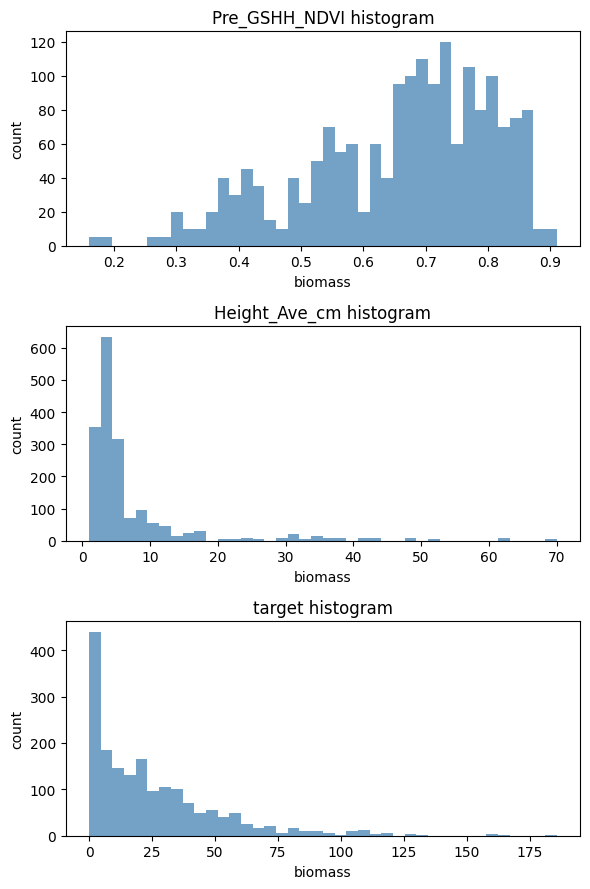

In [103]:
fig, axes = plt.subplots(len(feature_cols), 1, figsize=(6, 3 * len(feature_cols)), sharex=False)

for ax, col in zip(axes, feature_cols):
    train_df[col].plot.hist(ax=ax, bins=40, color="steelblue", alpha=0.75)
    ax.set_title(f"{col} histogram")
    ax.set_xlabel("biomass")
    ax.set_ylabel("count")

plt.tight_layout()

In [104]:
train_df['sample_id'].dtype

dtype('O')

In [105]:
train_df.describe()

,Pre_GSHH_NDVI,Height_Ave_cm,target
count,1785.000000,1785.000000,1785.000000
mean,0.657423,7.595985,24.782295
std,0.151972,10.273725,25.823738
min,0.160000,1.000000,0.000000
25%,0.560000,3.000000,4.818200
50%,0.690000,4.000000,18.200000
75%,0.770000,7.000000,35.940600
max,0.910000,70.000000,185.700000


In [106]:
train_df["Sampling_Date"] = pd.to_datetime(train_df["Sampling_Date"], format="%Y/%m/%d")

train_df["year"] = train_df["Sampling_Date"].dt.year
train_df["month"] = train_df["Sampling_Date"].dt.month
train_df["day"] = train_df["Sampling_Date"].dt.day

train_df[["year", "month", "day"]].head()

,year,month,day
0,2015,9,4
1,2015,9,4
2,2015,9,4
3,2015,9,4
4,2015,9,4


In [107]:
train_df.head(5)

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target,year,month,day
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000,2015,9,4
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984,2015,9,4
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751,2015,9,4
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735,2015,9,4
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750,2015,9,4


In [108]:
tabular_feats = ["Pre_GSHH_NDVI", "Height_Ave_cm", "State", "Species", "year", "month", "day"]

target_col = "target"

# Categorical features
cat_cols = ["State", "Species"]
train_df[cat_cols] = train_df[cat_cols].astype("category")

X = train_df[tabular_feats]
y = train_df[target_col]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=-1,
    num_leaves=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    categorical_feature=cat_cols,
    callbacks=[log_evaluation(period=10)],
)

# predict on test set
valid_pred = model.predict(X_val)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 6
[LightGBM] [Info] Start training from score 24.579136
[10]	valid_0's rmse: 25.2992	valid_0's l2: 640.048
[20]	valid_0's rmse: 24.7174	valid_0's l2: 610.952
[30]	valid_0's rmse: 24.237	valid_0's l2: 587.434
[40]	valid_0's rmse: 23.8501	valid_0's l2: 568.829
[50]	valid_0's rmse: 23.5206	valid_0's l2: 553.219
[60]	valid_0's rmse: 23.2244	valid_0's l2: 539.371
[70]	valid_0's rmse: 22.9808	valid_0's l2: 528.116
[80]	valid_0's rmse: 22.7721	valid_0's l2: 518.567
[90]	valid_0's rmse: 22.604	valid_0's l2: 510.94
[100]	valid_0's rmse: 22.4613	valid_0's l2: 504.509
[110]	valid_0's rmse: 22.3442	valid_0's l2: 499.263
[120]	valid_0's rmse: 22.2491	valid_0's l2: 495.024
[130]	valid_0's rmse: 22.1716	valid_0's l2: 491.

In [109]:
# ImageNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# pretrained model
backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
feature_extractor = torch.nn.Sequential(*(list(backbone.children())[:-1])).to(device)
feature_extractor.eval()

def extract_features(img_path: Path) -> torch.Tensor:
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = feature_extractor(x)
    return feat.detach().cpu().flatten()

def add_cnn_features(df, img_root: Path):
    feats = []
    for p in df["image_path"]:
        f = extract_features(img_root / p)
        feats.append(f.numpy())
    feat_df = pd.DataFrame(feats, columns=[f"cnn_{i}" for i in range(f.numel())])
    return pd.concat([df.reset_index(drop=True), feat_df], axis=1)

# Path to train and test images
img_root = Path("data")

train_with_feat = add_cnn_features(train_df, img_root)
test_with_feat = add_cnn_features(test_df, img_root)

cnn_feats = [c for c in train_with_feat.columns if c.startswith("cnn_")]
feats = tabular_feats + cnn_feats

In [110]:
feats

['Pre_GSHH_NDVI',
 'Height_Ave_cm',
 'State',
 'Species',
 'year',
 'month',
 'day',
 'cnn_0',
 'cnn_1',
 'cnn_2',
 'cnn_3',
 'cnn_4',
 'cnn_5',
 'cnn_6',
 'cnn_7',
 'cnn_8',
 'cnn_9',
 'cnn_10',
 'cnn_11',
 'cnn_12',
 'cnn_13',
 'cnn_14',
 'cnn_15',
 'cnn_16',
 'cnn_17',
 'cnn_18',
 'cnn_19',
 'cnn_20',
 'cnn_21',
 'cnn_22',
 'cnn_23',
 'cnn_24',
 'cnn_25',
 'cnn_26',
 'cnn_27',
 'cnn_28',
 'cnn_29',
 'cnn_30',
 'cnn_31',
 'cnn_32',
 'cnn_33',
 'cnn_34',
 'cnn_35',
 'cnn_36',
 'cnn_37',
 'cnn_38',
 'cnn_39',
 'cnn_40',
 'cnn_41',
 'cnn_42',
 'cnn_43',
 'cnn_44',
 'cnn_45',
 'cnn_46',
 'cnn_47',
 'cnn_48',
 'cnn_49',
 'cnn_50',
 'cnn_51',
 'cnn_52',
 'cnn_53',
 'cnn_54',
 'cnn_55',
 'cnn_56',
 'cnn_57',
 'cnn_58',
 'cnn_59',
 'cnn_60',
 'cnn_61',
 'cnn_62',
 'cnn_63',
 'cnn_64',
 'cnn_65',
 'cnn_66',
 'cnn_67',
 'cnn_68',
 'cnn_69',
 'cnn_70',
 'cnn_71',
 'cnn_72',
 'cnn_73',
 'cnn_74',
 'cnn_75',
 'cnn_76',
 'cnn_77',
 'cnn_78',
 'cnn_79',
 'cnn_80',
 'cnn_81',
 'cnn_82',
 'cnn_83',
 

In [111]:
X = train_with_feat[feats]
y = train_with_feat[target_col]
model.fit(X, y, categorical_feature=cat_cols)
test_pred = model.predict(test_with_feat[feats])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128933
[LightGBM] [Info] Number of data points in the train set: 1785, number of used features: 518
[LightGBM] [Info] Start training from score 24.782294


KeyError: "['Pre_GSHH_NDVI', 'Height_Ave_cm', 'State', 'Species', 'year', 'month', 'day'] not in index"